In [166]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

In [167]:
# Static methods abound! This isn't complicated enough to be worth storing state in the classes,
# so for now these are just wrappers around similar functionality

class DataGetter:
    @staticmethod
    def retrieve_fine_data(dataset='temp', t=0, region=None):
        if dataset in ('temp', 'temperature', 't2m'):
            data = netCDF4.Dataset("data/erai_t2m_daily.nc")
            data_name = 't2m'
        elif dataset in ('precip', 'precipitation', 'tp'):
            data = netCDF4.Dataset("data/erai_tp_daily.nc")
            data_name = 'tp'
        else:
            raise Exception('Unknown dataset {}'.format(dataset))
            
        return_data = np.array(data.variables[data_name][t, ::-1, :])
        if region is None:
            return return_data
        else:
            xmin, xmax, ymin, ymax = region
            return return_data[ymin:ymax, xmin:xmax]

    @staticmethod
    def coarsen(f_data, sep=2):
        return f_data[::sep, ::sep]


class Plotter:
    @staticmethod
    def plot_data(data, region=None, cmap=plt.get_cmap('jet')):
        plt.pcolormesh(data, cmap=cmap)
        plt.colorbar()
        if region is not None:
            xmin, xmax, ymin, ymax = region
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
    @classmethod
    def plot_diff(cls, p_data, f_data, region=None, cmap=plt.get_cmap('jet')):
        cls.plot_data(p_data - f_data, region, cmap=cmap)


def rms(p_data, f_data):
    return np.sqrt(np.sum((p_data - f_data) ** 2))

In [168]:
class Interpolator:
    
    @staticmethod
    def local_interpolater(interpolate_func):
        def local_interpolater_inner(c_data, f_shape, sep):
            return_data = np.empty(f_shape, dtype=np.float32)
            for y in range(f_shape[0]):
                for x in range(f_shape[1]):
                    return_data[y, x] = interpolate_func(x, y, c_data, sep)
            return return_data
        return local_interpolater_inner

    @staticmethod
    def _zero_func(x, y, c_data, sep):
        if y % sep == 0 and x % sep == 0:  # Known data
            return c_data[y // sep, x // sep]
        else:
            return 0

    @staticmethod
    def _mean_func(x, y, c_data, sep):
        c_shape = c_data.shape
        prop_x = (x % sep) / sep
        prop_y = (y % sep) / sep
        return (
                (1 - prop_x) * (1 - prop_y) * c_data[y // sep, x // sep] + 
                prop_x       * (1 - prop_y) * c_data[y // sep, (1 + x // sep) % c_shape[1]] +        # x axis wraps around; this is
                (1 - prop_x) * prop_y       * c_data[min(c_shape[0] - 1, 1 + y // sep), x // sep] +  # a first approximation to that
                prop_x       * prop_y       * c_data[min(c_shape[0] - 1, 1 + y // sep), (1 + x // sep) % c_shape[1]]
               )

    separate_data = staticmethod(local_interpolater.__func__(_zero_func.__func__))
    average_data = staticmethod(local_interpolater.__func__(_mean_func.__func__))

In [169]:
timestamp = 0
# tp or t2m for precipitation/temperature respectively
dataset = 't2m'
sep = 10
region = (410, 480, 210, 240)  # xmin, xmax, ymin, ymax

data_holder = DataGetter()
fine_data = data_holder.retrieve_fine_data(dataset, timestamp, region=None)
coarse_data = data_holder.coarsen(fine_data, sep)

averaged_data = Interpolator().average_data(coarse_data, fine_data.shape, sep)

In [170]:
rms(averaged_data, fine_data)

830.31036

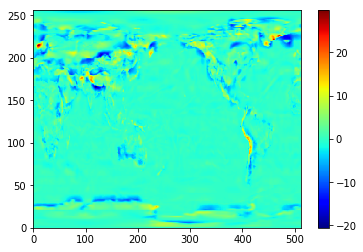

In [171]:
Plotter.plot_diff(averaged_data, fine_data)

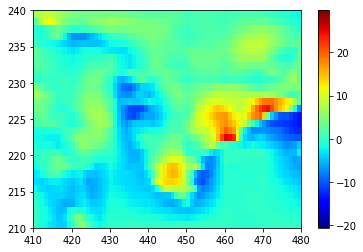

In [172]:
Plotter.plot_diff(averaged_data, fine_data, region)